<a href="https://colab.research.google.com/github/RonakMehta21/Advanced-Deep-Learning/blob/master/Assignment2/Augmentation_Techniques_on_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demonstrate Mixup, Label Smoothing, Cutout  and Test-time Augmentation Techniques on CIFAR dataset

Data augmentation is a technique often used to improve performance and reduce generalization error when training neural network models for computer vision problems. This colab uses CIFAR-10 dataset to demonstrate various augmentation techniques.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

### Import necessary packages

In [ ]:
#hide
!pip install fastai

In [5]:
#Importing necessary libraries
import torch
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Download the CIFAR dataset

In [6]:
path = untar_data(URLs.CIFAR);

In [7]:
path.ls()

[PosixPath('/root/.fastai/data/cifar10/test'),
 PosixPath('/root/.fastai/data/cifar10/labels.txt'),
 PosixPath('/root/.fastai/data/cifar10/train')]

In [8]:
path_train = path/'train'
path_test = path/'test'

In [9]:
path_train.ls()

[PosixPath('/root/.fastai/data/cifar10/train/deer'),
 PosixPath('/root/.fastai/data/cifar10/train/truck'),
 PosixPath('/root/.fastai/data/cifar10/train/ship'),
 PosixPath('/root/.fastai/data/cifar10/train/frog'),
 PosixPath('/root/.fastai/data/cifar10/train/airplane'),
 PosixPath('/root/.fastai/data/cifar10/train/horse'),
 PosixPath('/root/.fastai/data/cifar10/train/automobile'),
 PosixPath('/root/.fastai/data/cifar10/train/bird'),
 PosixPath('/root/.fastai/data/cifar10/train/dog'),
 PosixPath('/root/.fastai/data/cifar10/train/cat')]

In [10]:
path_test.ls()

[PosixPath('/root/.fastai/data/cifar10/test/deer'),
 PosixPath('/root/.fastai/data/cifar10/test/truck'),
 PosixPath('/root/.fastai/data/cifar10/test/ship'),
 PosixPath('/root/.fastai/data/cifar10/test/frog'),
 PosixPath('/root/.fastai/data/cifar10/test/airplane'),
 PosixPath('/root/.fastai/data/cifar10/test/horse'),
 PosixPath('/root/.fastai/data/cifar10/test/automobile'),
 PosixPath('/root/.fastai/data/cifar10/test/bird'),
 PosixPath('/root/.fastai/data/cifar10/test/dog'),
 PosixPath('/root/.fastai/data/cifar10/test/cat')]

### Create ImageDataBunch

In [11]:
bs = 64 # batch size
data = ImageDataBunch.from_folder(path=path, train='train', valid='test', size=32, bs=bs, ds_tfms=get_transforms(), num_workers=0)

# Normalize the dataset
data.normalize(cifar_stats)

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
deer,deer,deer,deer,deer
Path: /root/.fastai/data/cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
deer,deer,deer,deer,deer
Path: /root/.fastai/data/cifar10;

Test: None

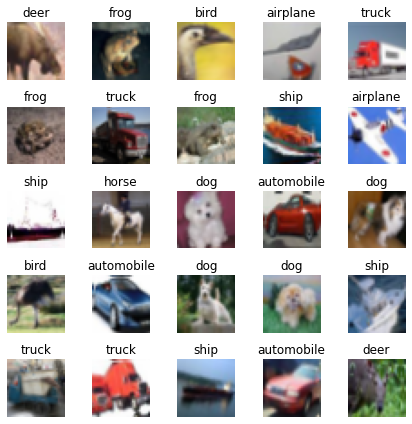

In [12]:
# Images from the dataset
data.show_batch(rows=5, figsize=(6,6))

### Train the ResNet34 on CIFAR dataset

In [13]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.344789,1.175039,0.594000,01:57
1,0.982399,0.885143,0.692800,01:57
2,0.841843,0.790707,0.723100,01:55
3,0.802708,0.723950,0.744200,01:56


The accuracy of the ResNet34 model with CIFAR-10 dataset is 74%.

## MixUp
Mixup is a data augmentation technique that adds a mix of pictures to the training set. In mixup, instead of feeding our network raw images, we take 2 images and do a linear combination of them. 

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=accuracy).mixup()
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy,time
0,1.742937,1.204755,0.579800,01:55
1,1.394170,0.942707,0.680300,01:58
2,1.324883,0.818289,0.724300,01:57
3,1.273506,0.805486,0.732700,01:55


The accuracy reduced to 73% from 74%.

## Label Smoothing
- Turns “hard” class label assignments to “soft” label assignments
- Operates directly on the labels themselves
- Can lead to a model that generalizes better

Label Smoothing helps us to deal with Overfitting and Overconfidence.

In [ ]:
learn = create_cnn(data, models.resnet34, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy,time
0,1.585856,1.439992,0.590500,01:57
1,1.263261,1.188676,0.694800,01:57
2,1.180472,1.132418,0.719600,01:56
3,1.144081,1.065413,0.747600,01:58


Label Smoothing performed better than MixUp and without data augmentation.

## Cutout
Cutout is a data augmentation technique where parts of the image are "cut out" or dropped. It has other variations such as cutmix, etc.

In [17]:
tfms = [cutout(n_holes=(1,4), length=(8, 20), p=1.),cutout(n_holes=(1,4), length=(8,20), p=1.)]

In [19]:
data = ImageDataBunch.from_folder(path=path, train='train', valid='test', size=32, bs=bs, ds_tfms=tfms, num_workers=0)
data.normalize(cifar_stats)

ImageDataBunch;

Train: LabelList (50000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
deer,deer,deer,deer,deer
Path: /root/.fastai/data/cifar10;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
deer,deer,deer,deer,deer
Path: /root/.fastai/data/cifar10;

Test: None

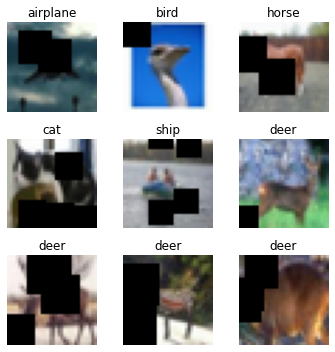

In [20]:
data.show_batch(rows=3, figsize=(5,5))

In [21]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2))

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy,time
0,1.822064,1.614176,0.409700,01:22
1,1.428816,1.313268,0.528400,01:20
2,1.300461,1.223539,0.562800,01:18
3,1.243700,1.197505,0.571400,01:19


## Test-time augmentation (TTA)

TTA is an application of data augmentation to the test dataset. Specifically, it involves creating multiple augmented copies of each image in the test set, having the model make a prediction for each, then returning an ensemble of those predictions.

`Learner.tta` returns predictions on the dataset using Test Time Augmentation

In [ ]:
preds,targs = learn.TTA()
accuracy(preds, targs).item()

0.7757999897003174

**Conclusion**: We can see using TTA has improved the accuracy of the model from 74% to 77% without any additional training.